<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./12_ltpy_WEkEO_harmonized_data_access_api.ipynb"><< 12 - WEkEO Harmonized Data Access API </a><span style=float:right;><a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb">212 - AC SAF - GOME-2 - Level 2 - Pre-process >></a></span>

# 2.1.1 AC SAF - GOME-2 -  Level 2 - Load and browse

AC SAF GOME-2 Level 2 data products are available as `near-real time (NRT)` and `offline`. NRT data products are available within three hours from sensing for the past two months. Offline products are available within 15 days from sensing at latest, but typical is a delay of 2-3 days.  AC SAF GOME-2 Level 2 data are disseminated in `HDF5` data format.

There are two modules on AC SAF GOME-2 Level 2 products. This module (2.1.1) shows how AC SAF GOME-2 Level 2 data can be loaded and explains the general structure. [Module 2.1.2](./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb) shows some pre-processing steps, such as `cloud masking`, that need to be applied to the data.

Find more information in the [GOME-2 NO2 (and other trace gases) Product User guides](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf).

#### This module has the following outline:
* [1 - Load and browse AC SAF GOME-2 Level 2 products](#load)
* [2 - Build a xarray DataArray object for a AC SAF GOME-2 Level 2 parameter](#build_xarray)
* [3 - Combine multiple HDF5 files in a xarray DataArray object](#combine)

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

<hr>

## <a id="load"></a>Load and browse GOME-2 AC SAF Level 2 products

AC SAF Level 2 data are disseminated in the `HDF5` format. [xarray](http://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) are two Python libraries you can use to access and manipulate datasets in `HDF5` format.

### Structure of AC SAF GOME-2 Level 2 product data files

The data in a HDF5 file is organized in groups. AC SAF GOME-2 Level 2 data contain five groups:
* `META_DATA`
 * Product Metadata
* `GEOLOCATION`
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* `TOTAL_COLUMNS`
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors
* `DETAILED_RESULTS`
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* `CLOUD_PROPERTIES`
 * Retrieve cloud properties

### Load HDF5 data with `netCDF4` and `xarray`

The aim is to store the content of the HDF5 file in a `xarray` object. The most efficient way is to do it in two steps: 
- (1) load a HDF5 `HDF5` file using `netCDF4` in `diskless non-persistence` mode, and 
- (2) Open a specific group of the `netCDF4` object as `xarray Dataset` object.

#### 1) Load a `HDF5` file using `netCDF4`

You can load a `HDF5` file with the `Dataset` constructor of the `netCDF4` library. Load the file in `diskless non-persistent` mode by setting the the `diskless` argument to `True` and the `persist` argument to `False`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

In [2]:
file_name = '../eodata/gome2/offline/2a/2019/08/18/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20190818000913_050_METOPA_66564_DLR_04.HDF5'
file = Dataset(file_name, diskless=True, persist=False)

groups = file.groups.keys()
groups

dict_keys(['CLOUD_PROPERTIES', 'DETAILED_RESULTS', 'GEOLOCATION', 'META_DATA', 'TOTAL_COLUMNS'])

Each group contains multiple variables. You can print out the variables of each group nicely formatted. This gives you a helpful overview of available parameters. You will mostly be interested in parameters of the `GEOLOCATION` and `TOTAL_COLUMNS` groups.

The overview shows you, that one AC SAF GOME-2 Level 2 data file contains trace gas total columns of six parameters:
* `BrO` - Hypobromite
* `H`<sub>`2`</sub>`O` - Water vapour
* `HCHO` - Formaldehyde
* `NO`<sub>`2`</sub> - Nitrogen Dioxide
* `O`<sub>`3`</sub> - Ozone
* `SO`<sub>`2`</sub> - Sulfur Dioxide

Additionally, the data file contains the tropospheric vertical column of Nitrogen Dioxide:
* `NO`<sub>`2`</sub> `Tropo` - Tropospheric Nitrogen Dioxide

In [3]:
for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].variables.keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              

DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - ESC                           - ESC_Error
   - FittingChiSquare              - FittingGoodness               - FittingNumberOfIterations
   - FittingRMS                    - IntensityWeightedCloudFraction- QualityFlags
   - SurfaceAlbedo                 - SurfaceConditionFlags         - SurfaceHeight
   - SurfacePressure               - VCD                           - VCD_Error

GEOLOCATI

#### 2) Open a `HDF5` group content as `xarray Dataset` object

In a next step, you can make use of `xarray.backends.NetCDF4DataStore` to open the `HDF5` group you are interested in as a xarray `Dataset` object. It is important to know that you can only get hold of one `HDF5` group item at the time.

As an example, you can load the `TOTAL_COLUMNS` group and open it as xarray `Dataset`.

In [4]:
tc = file['TOTAL_COLUMNS']
xr_tc = xr.open_dataset(xr.backends.NetCDF4DataStore(tc))
xr_tc

<xarray.Dataset>
Dimensions:         (phony_dim_19: 15149)
Dimensions without coordinates: phony_dim_19
Data variables:
    BrO             (phony_dim_19) float32 ...
    BrO_Error       (phony_dim_19) float32 ...
    H2O             (phony_dim_19) float32 ...
    H2O_Error       (phony_dim_19) float32 ...
    HCHO            (phony_dim_19) float32 ...
    HCHO_Error      (phony_dim_19) float32 ...
    NO2             (phony_dim_19) float32 ...
    NO2Tropo        (phony_dim_19) float32 ...
    NO2Tropo_Error  (phony_dim_19) float32 ...
    NO2_Error       (phony_dim_19) float32 ...
    O3              (phony_dim_19) float32 ...
    O3_Error        (phony_dim_19) float32 ...
    SO2             (phony_dim_19) float32 ...
    SO2_Error       (phony_dim_19) float32 ...

### Select and retrieve one specific parameter from a `xarray Dataset` object

Let's say, you are interested in the Tropospheric vertical column density of Nitrogen-Dioxide (NO<sub>2</sub>). You can retrieve the parameter using square brackets `[]` and the name of the parameter of interest. 

The resulting object is a `xarray DataArrary`, which has a shape of a 1-dimensional vector.

The `xarray DataArray` holds as well data attributes, which help to better understand the parameter, e.g. you get information about minimum and maximum values of the parameter and the unit of the data values.

In [5]:
no2 = xr_tc['NO2Tropo']
no2

<xarray.DataArray 'NO2Tropo' (phony_dim_19: 15149)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Dimensions without coordinates: phony_dim_19
Attributes:
    Unit:           mol/cm2
    Title:          Tropospheric vertical column density of NO2��U
    FillValue:      -1.0
    CheckSum:       -63449668
    ValueRangeMin:  -3250214400000000.0
    ValueRangeMax:  1.9275766e+16

## <a id="build_xarray"></a>Build a xarray `DataArray` object for a AC SAF GOME-2 Level 2 parameter

For easier handling and plotting of the parameters, you can combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

The constructor takes:
* `data`: an array of values (can be e.g. a numpy ndarray, but also a `Series`, `DataFrame` or `Panel`)
* `dims`: a list of dimension names
* `coords`: a list or dictionary of coordinates
* `attrs`: a dictionary of attributes to add to the instance

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` instance with latitude and longitude information and the NO<sub>2</sub> values as data values. The `DataArray` object contains around 15 000 ground pixels.

In [6]:
latitude = file['GEOLOCATION/LatitudeCentre']
longitude = file['GEOLOCATION/LongitudeCentre']

no2_da = xr.DataArray(
    no2,
    dims=('ground_pixel'),
    coords={
        'latitude': ('ground_pixel', latitude[:]),
        'longitude': ('ground_pixel', longitude[:])
    },
    attrs={'long_name': no2.Title, 'units': no2.Unit},
    name=no2.name
)

no2_da

<xarray.DataArray 'NO2Tropo' (ground_pixel: 15149)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.487015 63.81676 ... -62.004383
    longitude  (ground_pixel) float32 293.3269 293.0064 ... 105.10608 106.36275
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2��U
    units:      mol/cm2

You might need to generate a `xarray DataArray` from a file structure with 1-dimensional data vectors again. Let's define a function `generate_xr_from_1d_vec`, which returns the `xarray DataArray`.

In [18]:
def generate_xr_from_1D_vec(file,lat_path, lon_path, variable, parameter_name, longname, no_of_dims, unit):
    """ 
    Takes a netCDF4.Dataset or xarray.DataArray object and returns a xarray DataArray object with latitude / longitude
    information as coordinate information
    
    Parameters:
        file (netCDF4 data file): AC SAF Level 2 data file, loaded a netCDF4.Dataset or xarray.DataArray
        lat_path (str): internal path of the data file to the latitude information, e.g. 'GEOLOCATION/LatitudeCentre'
        lon_path (str): internal path of the data file to the longitude information, e.g. 'GEOLOCATION/LongitudeCentre'
        variable (array): extracted variable of interested
        parameter_name (str): parameter name, preferably extracted from the data file
        longname (str): Long name of the parameter, preferably extracted from the data file
        no_of_dims (int): Define the number of dimensions of your input array
        unit (str): Unit of the parameter, preferably extracted from the data file
    
    Returns:
        1 or 2-dimensional (depending on the given number of dimensions) xarray DataArray  with latitude / longitude information as coordinate information
    """
    latitude = file[lat_path]
    longitude = file[lon_path]
    param = variable 
    
    if (no_of_dims==1):
        param_da = xr.DataArray(
            param[:],
            dims=('ground_pixel'),
            coords={
                'latitude': ('ground_pixel', latitude[:]),
                'longitude': ('ground_pixel', longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=parameter_name
        )
    else:
        param_da = xr.DataArray(
            param[:],
            dims=["x","y"],
            coords={
                'latitude':(['x','y'],latitude[:]),
                'longitude':(['x','y'],longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=parameter_name
        )
        
    return param_da

### Plotting example of AC SAF GOME-2 Level 2 products - Single file with `PlateCarree` projection

You can continue to plot (visualize) the `DataArray` object. Python provides several plotting libraries. One extensive plotting library is [matplotlib](https://matplotlib.org/).

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is another useful Python package. Key features of `cartopy` are its object-oriented [projection definitions](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html), and its ability to transform points, lines, vectors, polygons and images between those projections. Cartopy includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.

As basemap, you can create a map in a `PlateCarree` projection. You can add coast- and gridlines. On top of the basemap, you plot the NO<sub>2</sub> values as a scatter plot, with the `scatter` function. As you might need to reuse the code for plotting, we define a plotting function called [visualize_l2](./ltpy_functions.ipynb#visualize_l2).

In [8]:
def visualize_l2(xr_dataarray, conversion_factor, projection, vmin, vmax, point_size, color_scale, unit, title, set_global=False):
    """ 
    Visualizes a xarray DataArray in a given projection using matplotlib's scatter function.
    
    Parameters:
        xr_dataarray(xarray DataArray): a one-dimensional xarray DataArray object with latitude and longitude information as coordinates
        conversion_factor (float): any number to convert the DataArray values
        projection (str): choose one of cartopy's projection, e.g. ccrs.PlateCarree()
        vmin (int): minimum number on visualisation legend
        vmax (int): maximum number on visualisation legend
        point_size (int): size of marker, e.g. 5
        color_scale (str): string taken from matplotlib's color ramp reference
        unit (str): define the unit to be added to the color bar
        title (str): define titl of the plot
        set_global (logical): set True, if the plot shall have a global coverage
    """
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    if set_global:
        ax.set_global()
    
    if (projection==ccrs.PlateCarree()):
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.xlabels_top=False
        gl.ylabels_right=False
        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'size':14}
        gl.ylabel_style={'size':14}

    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=point_size,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

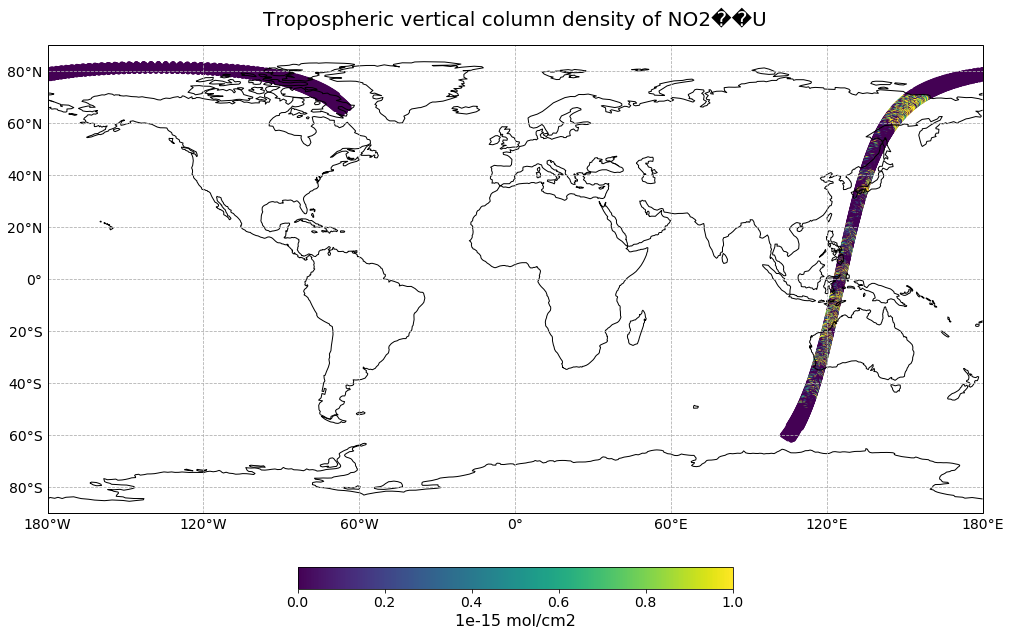

In [9]:
visualize_l2(no2_da, 1e-15, ccrs.PlateCarree(),0,1,20,'viridis',no2_da.units, no2_da.long_name, set_global=True)

The example above shows that one individual file contains the data for one ground track. If we want to see all the data that has been sensed on one individual day, we have to combine multiple HDF5 files.

## <a id="combine"></a>Combine multiple HDF5 files in a xarray `DataArray` object

AC SAF GOME-2 Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, you can combine the steps above in a for loop:

* 1) Open the HDF5 file with `netCDF4.Dataset` <br>
* 2) Retrieve information on `GEOLOCATION` and the `TOTAL_COLUMNS` parameter of interest
* 3) Generate a xarray `DataArray` and store it in a list of DataArrays
* 4) Concatenate the DataArrays into one `DataArray` with `xarray.concat`

You can combine the steps above in a function and call it [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr). At the same time, you can re-use the function [generate_xr_from_1D_vec](./ltpy_functions.ipynb#generate_xr_from_1D_vec), which was defined in the section before.

The result is a 1-dimensional `DataArray` containing the ground pixels of all GOME-2A files for one specific day. You can see that the `DataArray` object contains now multiple 100 000 ground pixels.

In [15]:
def load_l2_data_xr(directory, file_format, internal_filepath, parameter, lat_path, lon_path, no_of_dims, paramname, unit, longname):
    """ 
    Loads a Metop-A/B Level 2 dataset in HDF format and returns a xarray DataArray with all the ground pixels of all directory 
    files. Uses function 'generate_xr_from_1D_vec' to generate the xarray DataArray.
    
    Parameters:
        directory (str): directory where the HDF files are stored
        internal_filepath (str): internal path of the data file that is of interest, e.g. TOTAL_COLUMNS
        parameter (str): paramter that is of interest, e.g. NO2
        lat_path (str): name of latitude variable
        lon_path (str): name of longitude variable
        no_of_dims (int): number of dimensions of input array
        paramname (str): name of parameter
        unit (str): unit of the parameter, preferably taken from the data file
        longname (str): longname of the parameter, preferably taken from the data file
    
    Returns:
        1 or 2-dimensional xarray DataArray with latitude / longitude information as coordinate information
    """
    if(file_format=='netcdf'):
        fileList = glob.glob(directory+'*.nc')
    else:
        fileList = [os.path.join(directory, f) for f in os.listdir(directory)]
    datasets = []

    for i in fileList:
        tmp=Dataset(i)
        param=tmp[internal_filepath+'/'+parameter]
        da_tmp= generate_xr_from_1D_vec(tmp,lat_path, lon_path,
                                param, paramname, longname, no_of_dims, unit)
        if(no_of_dims==1):
            datasets.append(da_tmp)
        else:
            da_tmp_st = da_tmp.stack(ground_pixel=('x','y'))
            datasets.append(da_tmp_st)

    return xr.concat(datasets, dim='ground_pixel')

In [17]:
directory_2a = '../eodata/gome2/offline/2a/2019/08/18/'
no2_a_da_mf = load_l2_data_xr(directory_2a, 'hdf5', 'TOTAL_COLUMNS', 'NO2Tropo', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='NO2Tropo', unit='mol/cm\u00b2', longname='Tropospheric vertical column density of NO2')
no2_a_da_mf

<xarray.DataArray 'NO2Tropo' (ground_pixel: 223224)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.854996 64.1843 ... -63.2107 -63.55267
    longitude  (ground_pixel) float32 323.52814 323.20117 ... 343.05618
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

### Plotting example of AC SAF Level 2 products - Multiple files with `Mollweide` projection

The plotting example above showed that the `PlateCarree` projection is not the best suited projection for representing the GOME-2 ground tracks. Let's try to visualize all ground tracks of one day in `Mollweide` projection. You can change the basemap to the `Mollweide` projection and add a transform argument to your scatter plot, in order to transform the coordinates to a `Mollweide` projection.

We define the function [visualize_gome_mollweide](./ltpy_functions.ipynb#visualize_gome_mollweide) to visualize the data in a `Mollweide` projection, which is more appropriate to visualize the ground tracks.

In [13]:
def visualize_gome_mollweide(xr_dataarray, conversion_factor, color_scale, marker_size, vmin, vmax):
    """ 
    Visualizes a xarray dataarray in a mollweide projection using matplotlib's scatter function.
    
    Parameters:
        xr_dataarray (xarray DataArray): a three-dimensional xarray DataArray object
        conversion_factor (float): any number to convert the DataArray values
        color_scale (str): string taken from matplotlib's color ramp reference 
        marker_size (str): size of the marker
        vmin (int): minimum number on visualisation legend
        vmax (int): maximum number on visualisation legend
    """
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=ccrs.Mollweide())

    ax.coastlines()
    ax.set_global()

    ax.gridlines(linestyle='--')
    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=marker_size,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

<br>

Let's visualize the ground tracks of all the measured values of MetOp-A for 18 August 2019. We see that the unfiltered data may contain negative values. Measurements can further be influenced by clouds. Thus, the next step is to mask the data and filter invalid ground pixels.

Go to [module 2.1.2](./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb) to see further pre-processing steps for AC SAF Level 2 data.

In [ ]:
visualize_gome_mollweide(no2_a_da_mf, 1e-15, 'viridis', 5, no2_a_da_mf.data.min(), no2_a_da_mf.data.max())

<br>

<br>

<a href="./12_ltpy_WEkEO_harmonized_data_access_api.ipynb"><< 12 - WEkEO Harmonized Data Access API </a><span style=float:right;><a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb">212 - AC SAF - GOME-2 - Level 2 - Pre-process >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>